## MMAS 823 Financial Analytics - Individual Assignment 2
### Anthony Ramelo - 20499391

## Part 1: Historical Data and Stock Betas Analysis (12 points)
(1) Data Collection (2 points)

In [1]:
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt

start_date = dt.datetime(2015,1,2)
end_date   = dt.datetime(2025,1,2)  # or present

tickers = ["RACE", "TSLA", "JNJ", "XOM", "^GSPC"]

# 1.1 Download weekly data from Yahoo
data = yf.download(tickers, start=start_date, end=end_date, interval="1wk", auto_adjust=True)
# Alternatively: download daily, then resample to weekly

# 1.2 Extract 'Close' prices (if auto_adjust=True, 'Close' is effectively adjusted)
weekly_close = data["Close"].dropna(how="all")

# 1.3 Download 3-month T-bill from FRED
# For example: "TB3MS" = 3-Month Treasury Bill: https://fred.stlouisfed.org/series/TB3MS
rf_data = pdr.DataReader("TB3MS", "fred", start_date, end_date)
# Resample to match weekly frequency
rf_weekly = rf_data.resample("W-FRI").ffill()  # forward-fill
# Convert from annual % to weekly decimal
rf_weekly["rf_weekly"] = rf_weekly["TB3MS"] / 100.0 / 52.0

[*********************100%***********************]  5 of 5 completed


(2) Beta Estimation (4 points)

In [2]:
import pandas as pd
import statsmodels.api as sm

# 2.1 Compute weekly returns
weekly_returns = weekly_close.pct_change().dropna()

# 2.2 Align risk-free to same index
rf_weekly = rf_weekly.reindex(weekly_returns.index, method="ffill")
risk_free = rf_weekly["rf_weekly"]

# 2.3 Market returns minus risk-free
mkt_excess = weekly_returns["^GSPC"] - risk_free

# 2.4 For each stock, run OLS
for stock in ["RACE", "TSLA", "JNJ", "XOM"]:
    if stock not in weekly_returns.columns:
        # Possibly skip if no data
        continue
    
    stock_excess = weekly_returns[stock] - risk_free
    
    X = sm.add_constant(mkt_excess)
    y = stock_excess
    
    model = sm.OLS(y, X, missing="drop").fit()
    print(f"\n*** Full Sample CAPM: {stock} ***")
    print(model.summary())
    
    # Identify alpha, beta, R^2, etc.
    # alpha = model.params["const"]
    # beta  = model.params["^GSPC"]
    # r2    = model.rsquared
    # etc.


*** Full Sample CAPM: RACE ***
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05154
Date:                Sat, 01 Feb 2025   Prob (F-statistic):              0.820
Time:                        12:42:06   Log-Likelihood:                 2065.9
No. Observations:                 960   AIC:                            -4128.
Df Residuals:                     958   BIC:                            -4118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.002

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_94661/4233722595.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_returns = weekly_close.pct_change().dropna()


(3) Moving Window (Rolling) Regression (6 points)

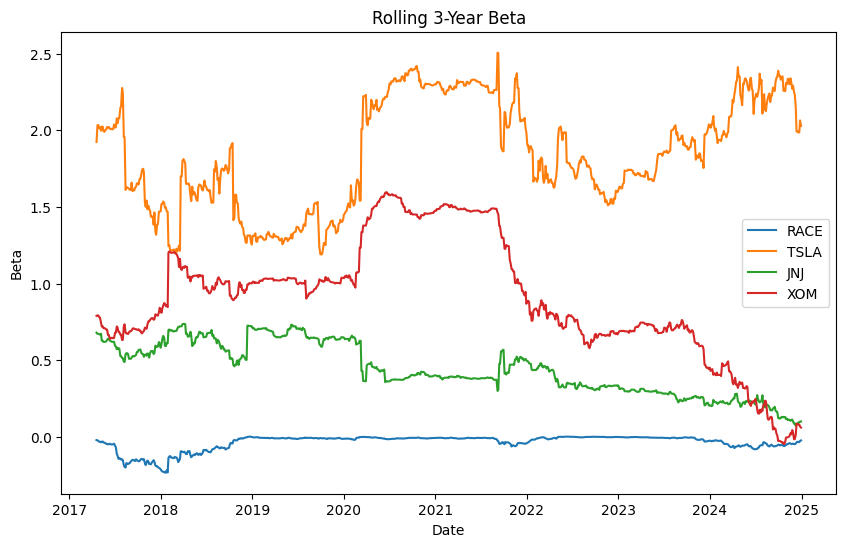

In [3]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 157  # ~3 years of weekly data
rolling_betas = {}

for stock in ["RACE", "TSLA", "JNJ", "XOM"]:
    betas_for_stock = []
    dates_for_stock = []

    stock_excess = weekly_returns[stock] - risk_free
    
    # Only proceed if we have enough data
    if len(stock_excess) < window_size:
        continue
    
    for start_idx in range(len(stock_excess) - window_size + 1):
        end_idx = start_idx + window_size
        # Slice window
        y_win = stock_excess.iloc[start_idx:end_idx]
        X_win = mkt_excess.iloc[start_idx:end_idx]
        
        # Build DF for OLS
        df_win = pd.DataFrame({
            "stock_excess": y_win,
            "mkt_excess": X_win
        }).dropna()
        
        if len(df_win) == 0:
            continue

        # OLS
        X_ols = sm.add_constant(df_win["mkt_excess"])
        y_ols = df_win["stock_excess"]
        model_win = sm.OLS(y_ols, X_ols).fit()
        
        beta_win = model_win.params["mkt_excess"]
        betas_for_stock.append(beta_win)

        # Associate with end of window date
        window_date = df_win.index[-1]
        dates_for_stock.append(window_date)

    # Store as a pandas Series for easy plotting
    rolling_betas[stock] = pd.Series(data=betas_for_stock, index=dates_for_stock)

# Plot rolling betas
plt.figure(figsize=(10,6))
for stock in rolling_betas:
    plt.plot(rolling_betas[stock].index, rolling_betas[stock], label=stock)
plt.legend()
plt.title("Rolling 3-Year Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.show()

## Part 2: Logit Regression for Credit Default (10 pts)Part 

2.1 Apply the Logit Regression

            LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186

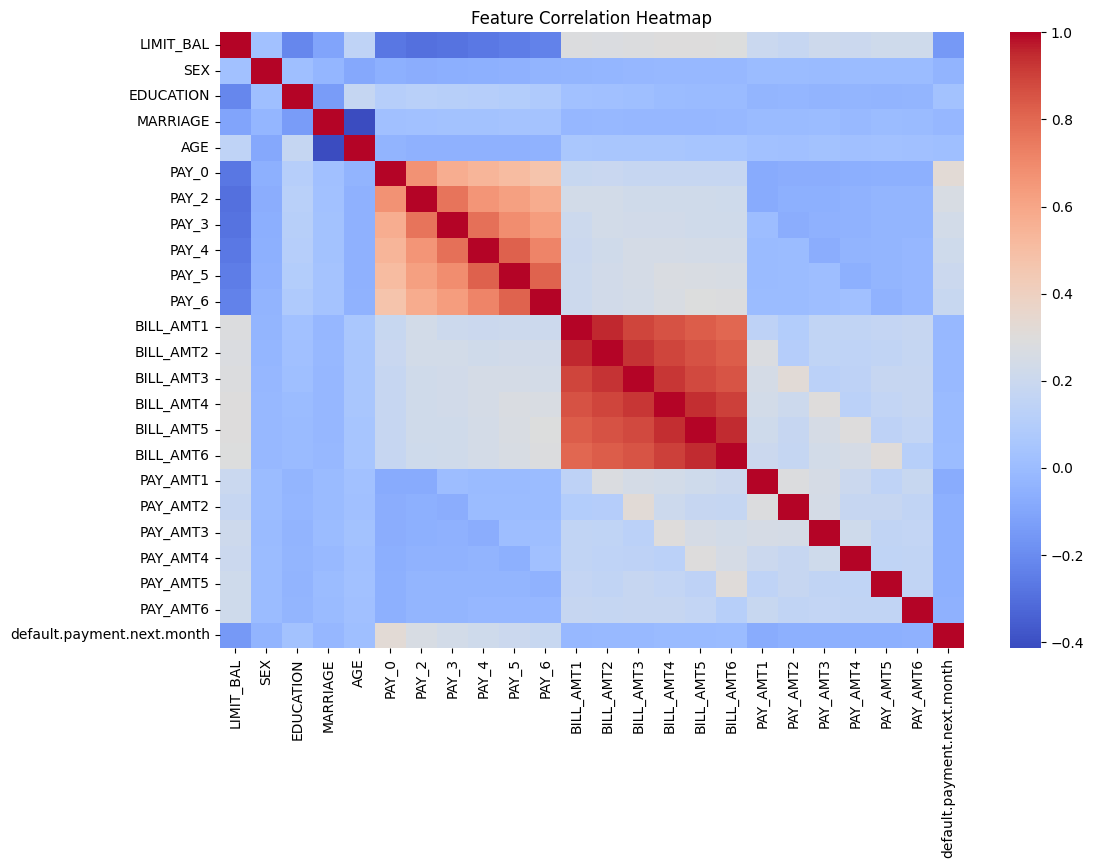

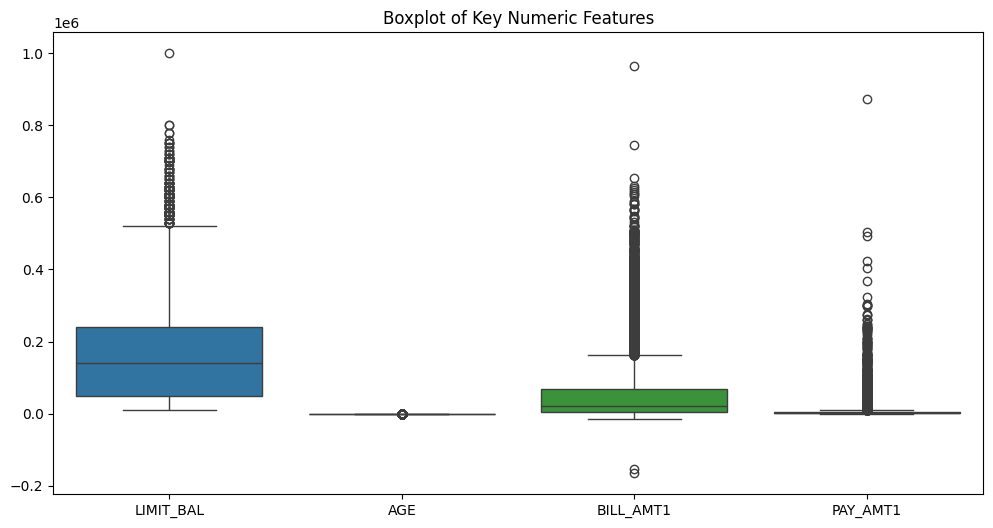

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load the dataset
file_path = "Credit Card Data.xlsx"
df = pd.read_excel(file_path, sheet_name='Credit Card Data')

# Drop ID column (not useful for modeling)
df.drop(columns=['ID'], inplace=True)

### 1. Exploratory Data Analysis (EDA)
# Summary statistics and missing values
print(df.describe())
print(df.isnull().sum())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1']])
plt.title("Boxplot of Key Numeric Features")
plt.show()

### 2. Data Cleaning & Preprocessing
# Fix categorical variables (EDUCATION & MARRIAGE categories)
df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})

# Define feature matrix X and target variable y
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']

# Identify categorical and numerical columns
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
numerical_features = X.columns.difference(categorical_features)

# Define column transformer for preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])


# 2.2 Repeat with a different Train-Test Sample

Accuracy (First Split): 0.8207
[[7760  162]
 [1631  447]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      7922
           1       0.73      0.22      0.33      2078

    accuracy                           0.82     10000
   macro avg       0.78      0.60      0.61     10000
weighted avg       0.81      0.82      0.78     10000

Accuracy (Second Split): 0.8029
[[7482  259]
 [1712  547]]
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      7741
           1       0.68      0.24      0.36      2259

    accuracy                           0.80     10000
   macro avg       0.75      0.60      0.62     10000
weighted avg       0.78      0.80      0.76     10000



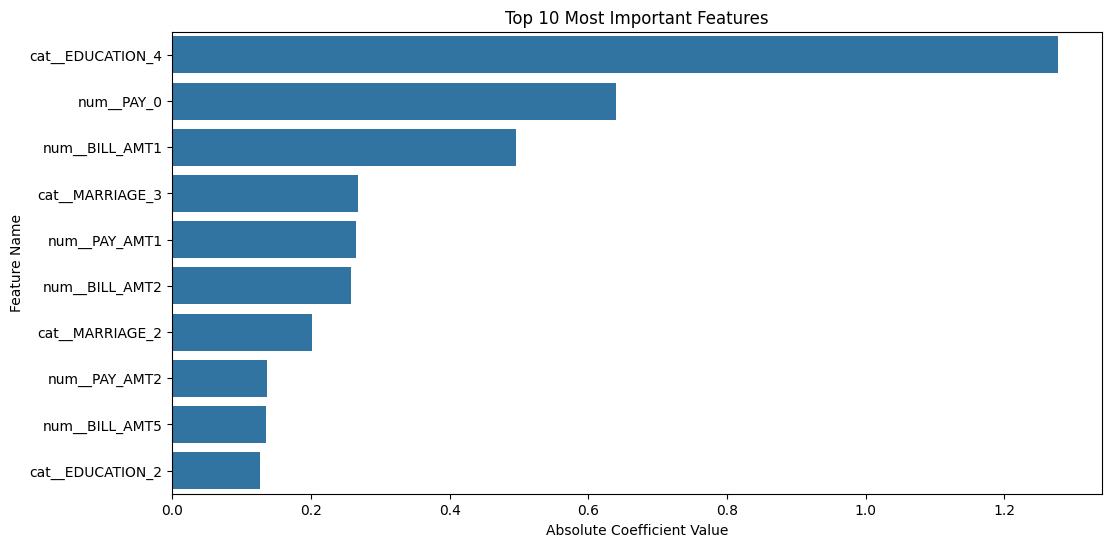

Random Forest Accuracy: 0.8269
[[7592  330]
 [1401  677]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      7922
           1       0.67      0.33      0.44      2078

    accuracy                           0.83     10000
   macro avg       0.76      0.64      0.67     10000
weighted avg       0.81      0.83      0.80     10000

XGBoost Accuracy: 0.7895
[[6698 1224]
 [ 881 1197]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      7922
           1       0.49      0.58      0.53      2078

    accuracy                           0.79     10000
   macro avg       0.69      0.71      0.70     10000
weighted avg       0.80      0.79      0.80     10000



In [24]:
# Train-Test Splits
X_train_1, X_test_1, y_train_1, y_test_1 = X.iloc[:20000], X.iloc[20000:], y.iloc[:20000], y.iloc[20000:]
X_train_2, X_test_2, y_train_2, y_test_2 = X.iloc[10000:], X.iloc[:10000], y.iloc[10000:], y.iloc[:10000]

# Apply transformations
X_train_1 = preprocessor.fit_transform(X_train_1)
X_test_1 = preprocessor.transform(X_test_1)
X_train_2 = preprocessor.fit_transform(X_train_2)
X_test_2 = preprocessor.transform(X_test_2)

### 3. Logistic Regression (First Split)
log_reg_1 = LogisticRegression(max_iter=500, random_state=42)
log_reg_1.fit(X_train_1, y_train_1)
y_pred_1 = log_reg_1.predict(X_test_1)
print("Accuracy (First Split):", accuracy_score(y_test_1, y_pred_1))
print(confusion_matrix(y_test_1, y_pred_1))
print(classification_report(y_test_1, y_pred_1))

# Logistic Regression (Second Split)
log_reg_2 = LogisticRegression(max_iter=500, random_state=42)
log_reg_2.fit(X_train_2, y_train_2)
y_pred_2 = log_reg_2.predict(X_test_2)
print("Accuracy (Second Split):", accuracy_score(y_test_2, y_pred_2))
print(confusion_matrix(y_test_2, y_pred_2))
print(classification_report(y_test_2, y_pred_2))

### 4. Feature Importance
feature_names = preprocessor.get_feature_names_out()
coefficients = log_reg_1.coef_.flatten()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance['Coefficient'][:10], y=feature_importance['Feature'][:10])
plt.title('Top 10 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

### 5. Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_1, y_train_1)
y_pred_rf = rf_model.predict(X_test_1)
print("Random Forest Accuracy:", accuracy_score(y_test_1, y_pred_rf))
print(confusion_matrix(y_test_1, y_pred_rf))
print(classification_report(y_test_1, y_pred_rf))

### 6. XGBoost Model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, 
                          scale_pos_weight=(y_train_1.value_counts()[0] / y_train_1.value_counts()[1]),
                          random_state=42)
xgb_model.fit(X_train_1, y_train_1)
y_pred_xgb = xgb_model.predict(X_test_1)
print("XGBoost Accuracy:", accuracy_score(y_test_1, y_pred_xgb))
print(confusion_matrix(y_test_1, y_pred_xgb))
print(classification_report(y_test_1, y_pred_xgb))


Part 3

Number of principal components explaining 99% variance: 3


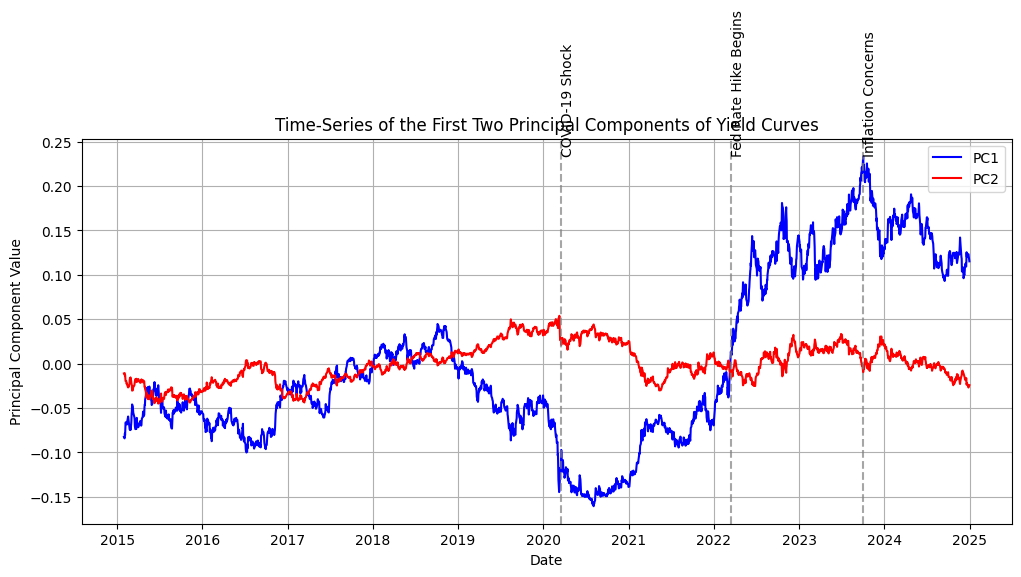

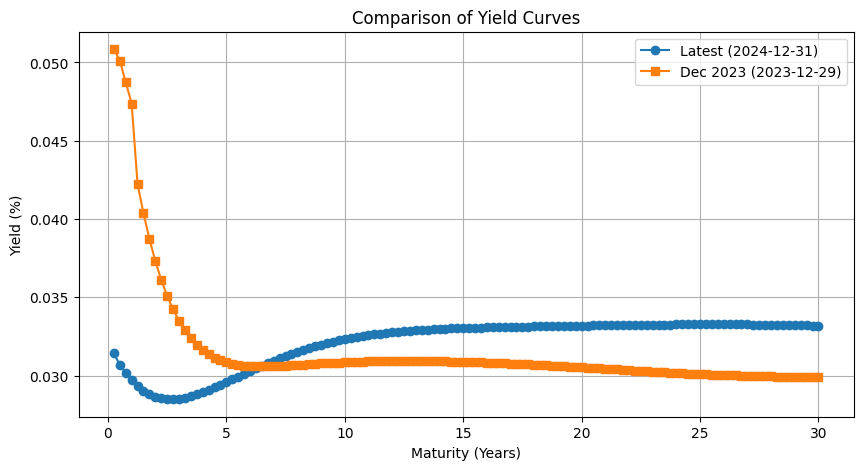

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the Excel file
file_path = "yield_curves.xlsx"
xls = pd.ExcelFile(file_path)

# Load the data from the 'yield_curves' sheet
df = pd.read_excel(xls, sheet_name='yield_curves')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Drop any unexpected column
df = df.drop(columns=[' '], errors='ignore')

# Convert yield columns to numeric, handling errors
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Drop NaN values
df_clean = df.dropna()

# Extract yield data
yield_data = df_clean.iloc[:, 1:].values

# Perform PCA
pca = PCA()
pca.fit(yield_data)

# Compute explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of principal components explaining 99% variance
num_components = np.argmax(explained_variance >= 0.99) + 1
print(f"Number of principal components explaining 99% variance: {num_components}")

# Project the yield data onto the first two principal components
pca_scores = pca.transform(yield_data)[:, :2]

# Create a DataFrame for visualization
pca_df = pd.DataFrame({
    'Date': df_clean['Date'],
    'PC1': pca_scores[:, 0],
    'PC2': pca_scores[:, 1]
})

# Plot the time-series of the first two principal components
plt.figure(figsize=(12, 5))
plt.plot(pca_df['Date'], pca_df['PC1'], label='PC1', color='blue')
plt.plot(pca_df['Date'], pca_df['PC2'], label='PC2', color='red')

# Add vertical markers for key economic events
key_events = {
    '2020-03-15': 'COVID-19 Shock',
    '2022-03-16': 'Fed Rate Hike Begins',
    '2023-10-01': 'Inflation Concerns'
}

for date, label in key_events.items():
    plt.axvline(pd.to_datetime(date), color='gray', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), max(pca_df['PC1']), label, rotation=90, verticalalignment='bottom')

plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.title('Time-Series of the First Two Principal Components of Yield Curves')
plt.legend()
plt.grid()
plt.show()

# Extract the most recent date and the last date of December 2023
latest_date = df['Date'].max()
dec_2023_date = df[df['Date'].dt.strftime('%Y-%m') == '2023-12']['Date'].max()

# Get the yield curve data for these two dates
latest_yields = df[df['Date'] == latest_date].iloc[:, 1:].T
dec_2023_yields = df[df['Date'] == dec_2023_date].iloc[:, 1:].T

# Get the maturities (column headers except 'Date')
maturities = df.columns[1:].astype(float)

# Plot the yield curves
plt.figure(figsize=(10, 5))
plt.plot(maturities, latest_yields, label=f'Latest ({latest_date.date()})', marker='o')
plt.plot(maturities, dec_2023_yields, label=f'Dec 2023 ({dec_2023_date.date()})', marker='s')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Comparison of Yield Curves')
plt.legend()
plt.grid()
plt.show()


# What factors were important in that change in your view? Briefly explain.”	

	•	Key events like COVID-19, Fed rate hikes, and inflation concerns drove major yield movements.
	•	Central bank policy expectations: The initial rate hikes in 2022 pushed up short-term yields, but now, with inflation uncertainty, long-term yields have also risen.
	•	Market sentiment on future interest rates: The flattening of the yield curve suggests fewer expected rate cuts in the near future.
    

# How many principal components explain 99% of variance?
The text “Number of principal components explaining 99% variance: 3” confirms that three principal components explain 99% of the variance in the yield curve data.